<a href="https://colab.research.google.com/github/schumbar/CMPE258/blob/main/assignment_07/CMPE258_Assignment07_Part03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 07 Part 03 - Zero-Shot Transfer Learning
By Shawn Chumbar

## Assignment Description
Write a colab showcasing the following:

- zero-shot transfer learning using the CLIP model
- transfer learning using state of art models from tfhub (Eg: use bigtransfer for example)

### References Used
1. [How to Try CLIP: OpenAI’s Zero-Shot Image Classifier](https://towardsdatascience.com/how-to-try-clip-openais-zero-shot-image-classifier-439d75a34d6b)
2. [Image Classification using BigTransfer (BiT)](https://keras.io/examples/vision/bit/)
3. [Transfer learning with TensorFlow Hub](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub)

## Clone CLIP Repo

In [1]:
roboflow_api_key = 'REPLACE-ME'

In [2]:
#clone the CLIP repository
!git clone https://github.com/openai/CLIP.git
%cd CLIP

Cloning into 'CLIP'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 251 (delta 3), reused 3 (delta 0), pack-reused 243
Receiving objects: 100% (251/251), 8.93 MiB | 34.89 MiB/s, done.
Resolving deltas: 100% (127/127), done.
/content/CLIP


## Install Imports

#### README
After installing packages below, you may be asked to restart the runtime.   
**DO NOT SELECT YES.**



In [3]:
# Install required packages
!pip install certifi
!pip install cycler
!pip install tensorflow-hub
!pip install torch
!pip install torchvision
!pip install ftfy
!pip install regex
!pip install roboflow
# !pip install torch==1.11.0 torchvision==0.12.0 ftfy regex

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [4]:
# Import necessary libraries
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import torch
from PIL import Image
import glob
from roboflow import Roboflow
import matplotlib.pyplot as plt


## Zero Shot Transfer Learning with CLIP

In [6]:
rf = Roboflow(api_key=roboflow_api_key)
project = rf.workspace("popular-benchmarks").project("nike-adidas-and-converse-shoes-classification")
version = project.version(6)
dataset = version.download("folder")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Nike-Adidas-and-Converse-Shoes-Classification-6 in folder:: 100%|██████████| 3141/3141 [00:00<00:00, 7343.47it/s]


In [7]:
dataset.location

'/content/CLIP/Nike-Adidas-and-Converse-Shoes-Classification-6'

In [8]:
import os
#our the classes and images we want to test are stored in folders in the test set
class_names = os.listdir(dataset.location + '/test/')
class_names

['converse', 'nike', 'adidas']

In [9]:
#we auto generate some example tokenizations in Roboflow but you should edit this file to try out your own prompts
#CLIP gets a lot better with the right prompting!
#be sure the tokenizations are in the same order as your class_names above!
%cat {dataset.location}/test/_tokenization.txt

cat: /content/CLIP/Nike-Adidas-and-Converse-Shoes-Classification-6/test/_tokenization.txt: No such file or directory


In [10]:
#edit your prompts as you see fit here, be sure the classes are in teh same order as above
%%writefile {dataset.location}/test/_tokenization.txt
The converse sign in fashion
The Nike sign in fashion
The Adidas sign in fashion

Writing /content/CLIP/Nike-Adidas-and-Converse-Shoes-Classification-6/test/_tokenization.txt


In [11]:
candidate_captions = []
with open(dataset.location + '/test/_tokenization.txt') as f:
    candidate_captions = f.read().splitlines()

### Run CLIP Inference on Dataset

In [12]:
import clip


def argmax(iterable):
    return max(enumerate(iterable), key=lambda x: x[1])[0]

device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)

correct = []

#define our target classificaitons, you can should experiment with these strings of text as you see fit, though, make sure they are in the same order as your class names above
text = clip.tokenize(candidate_captions).to(device)

for cls in class_names:
    class_correct = []
    test_imgs = glob.glob(dataset.location + '/test/' + cls + '/*.jpg')
    for img in test_imgs:
        #print(img)
        image = transform(Image.open(img)).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text)

            logits_per_image, logits_per_text = model(image, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()

            pred = class_names[argmax(list(probs)[0])]
            #print(pred)
            if pred == cls:
                correct.append(1)
                class_correct.append(1)
            else:
                correct.append(0)
                class_correct.append(0)

    print('accuracy on class ' + cls + ' is :' + str(sum(class_correct)/len(class_correct)))
print('accuracy on all is : ' + str(sum(correct)/len(correct)))


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 131MiB/s]


accuracy on class converse is :0.9473684210526315
accuracy on class nike is :1.0
accuracy on class adidas is :0.9210526315789473
accuracy on all is : 0.9397590361445783


## Transfer Learning with State-of-Art Models from TF Hub

### Loading and Preprocessing Dataset

In [13]:
# Set the image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load and preprocess the dataset
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [14]:
train_generator = train_datagen.flow_from_directory(
    '/content/CLIP/Nike-Adidas-and-Converse-Shoes-Classification-6/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

Found 2304 images belonging to 3 classes.


In [15]:
validation_generator = train_datagen.flow_from_directory(
    '/content/CLIP/Nike-Adidas-and-Converse-Shoes-Classification-6/valid',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 33 images belonging to 1 classes.


### Loading the pre-trained model from TFHub (imagenet)

In [16]:
# Load a pre-trained model from TF Hub
base_model = hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
                            input_shape=(224, 224, 3), trainable=False)

### Creating/Compiling Model

In [17]:
# Create the model architecture
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

In [18]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Model Training

In [19]:
# Train the model
epochs = 10
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

In [20]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

Epoch 1/10
72/72 [==============================] - 11s 65ms/step - loss: 0.8156 - accuracy: 0.6740 - val_loss: 4.1577 - val_accuracy: 0.1562
Epoch 2/10
72/72 [==============================] - 4s 58ms/step - loss: 0.4927 - accuracy: 0.8047 - val_loss: 4.3686 - val_accuracy: 0.4375
Epoch 3/10
72/72 [==============================] - 5s 62ms/step - loss: 0.4120 - accuracy: 0.8355 - val_loss: 4.4488 - val_accuracy: 0.5625
Epoch 4/10
72/72 [==============================] - 5s 63ms/step - loss: 0.3382 - accuracy: 0.8707 - val_loss: 4.7012 - val_accuracy: 0.2188
Epoch 5/10
72/72 [==============================] - 5s 64ms/step - loss: 0.2667 - accuracy: 0.9028 - val_loss: 4.8659 - val_accuracy: 0.3125
Epoch 6/10
72/72 [==============================] - 4s 57ms/step - loss: 0.2248 - accuracy: 0.9141 - val_loss: 5.1590 - val_accuracy: 0.1875
Epoch 7/10
72/72 [==============================] - 4s 57ms/step - loss: 0.1785 - accuracy: 0.9340 - val_loss: 5.3531 - val_accuracy: 0.3438
Epoch 8/10
7

### Model Evaluation

In [21]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(validation_generator, steps=validation_steps)

1/1 [==============================] - 0s 122ms/step - loss: 5.8577 - accuracy: 0.1875


In [22]:
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Test Loss: 5.857702732086182
Test Accuracy: 0.1875


### Data Visualizations

#### Training and Validation Accuracy

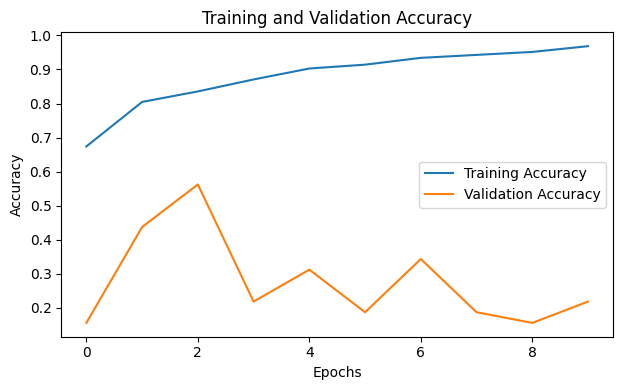

In [23]:
# Visualize the training accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

#### Training and Validation Loss

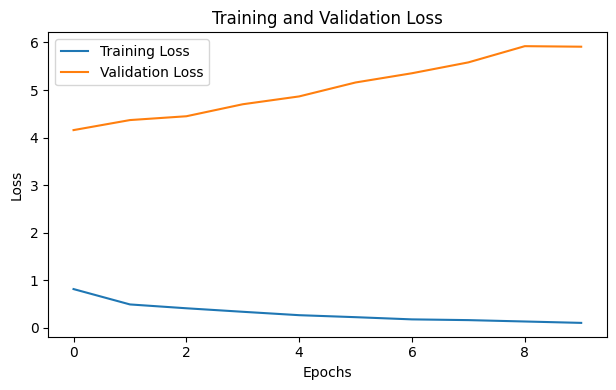

In [24]:
# Visualize the training accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()